In [1]:
import JSSP
import gym
import numpy as np
import matplotlib.pyplot as plt

# Environment Initialization

In [2]:
def create_env(instance_path):
    env_name = "JSSP-v0"
    env = gym.make(env_name, instance_path = instance_path)
    print("Environment Created for: ", instance_path)
    print("Observation space: \n", env.observation_space)
    print("Action space: \n", env.action_space)
    return env

In [3]:
# small environment: 2 jobs 3 machines 3 operations
env_s = create_env("../Instances/instance1.txt") # -53
# medium environment: 6 jobs 6 machines 6 operations
env_m = create_env("../Instances/instance5.txt") # -55
# large environment: 10 jobs 6 machines 6 operations
env_l = create_env("../Instances/instance4.txt") # -42
# extra large environment: 10 jobs 11 machines 10 operations
env_xl = create_env("../Instances/instance3.txt") # -959

pygame 2.1.2 (SDL 2.0.18, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Environment Created for:  ../Instances/instance1.txt
Observation space: 
 Box([-2 -2  0  0], [2 2 2 2], (4,), int64)
Action space: 
 Discrete(7)
Environment Created for:  ../Instances/instance5.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2  0  0  0  0  0  0], [5 5 5 5 5 5 5 5 5 5 5 5], (12,), int64)
Action space: 
 Discrete(15)
Environment Created for:  ../Instances/instance4.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5], (20,), int64)
Action space: 
 Discrete(755)
Environment Created for:  ../Instances/instance3.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [10 10 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9], (20,), int64)
Action space: 
 Discrete(259)


# Algorithms

## Random Sampling

In [4]:
def random_sampling(env, episodes, print_steps = False):
    """
    baseline solution to FJSSP, randomly selects actions for each episode and selects
    best set of actions
    :param print_steps: boolean dictating whether to print each step
    :param env: FJSSP environment
    :param episodes: number of episodes
    :return:
    """
    env.reset()
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    for episode in range(1, episodes+1):
        env.reset()
        done = False
        score = 0
        action_list = []
        time_list = []
        while not done:
            #env.render()
            action = env.action_space.sample()
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
            n_state, reward, done, info = env.step(action)
            score+=reward
        if print_steps:
            print('Episode:{} Total_reward:{}'.format(episode, score))
        if score >= max_score:
            max_score = score
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
    print('From {}th Episode best policy has reward {}'.format(max_episode, max_score))
    return max_score, max_action_list, max_time_list

## Q-Learning

In [5]:
def policy(state, Q, epsilon, num_actions):
    """
    function that returns the probability for action choosing based on a given Q-function and epsilon at this state
    :param state: tuple of order 2 * number of jobs
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param epsilon: for epsilon greedy choosing algorithm
    :param num_actions: number of legal actions at this state
    :return: an array of order num_actions containing probability for action choosing at this state
    """
    # if state has been visited before, use epsilon greedy algorithm to generate probability
    if state in Q:
        best_action = np.argmax(Q[state])
        Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities

    # if state hasn't been visited before, choose action with equal probability
    Action_probabilities = np.ones(num_actions, dtype = float) / num_actions
    return Action_probabilities

In [6]:
def update_estimation(Q_estimation, estimation_list, total_reward):
    """
    update the Q_estimation table
    1. If state action pair is not estimated, set its Q value
    2. If pair has been estimated, only update in case of a more optimal reward
    :param total_reward: total reward of single episode run
    :param Q_estimation: estimation of Q values table
    :param estimation_list: list of [state, action, reward]
    :return: updated Q_estimation table
    """
    current_reward = total_reward
    for state, action, reward in estimation_list:
        state_action_estimation = Q_estimation[state][action]
        # 1. if state action pair hasn't been estimated
        if state_action_estimation == 0:
            Q_estimation[state][action] = current_reward
        # 2. if current estimation is a more optimal solution
        elif state_action_estimation <= current_reward:
            Q_estimation[state][action] = current_reward
        current_reward -= reward

    return Q_estimation


In [7]:
def q_estimation(env, epis, epsilon = .9, print_steps = False):
    """
    q-learning algorithm that returns the best policy, and data for each episode
    Once an episode is done, from first state, action pair to the last one:
    1. check if current q value is greater than reward estimation
    2. if yes, update the q value <- reward estimation
    3. if no, reward estimation -= current reward of state action pair
    :param print_steps: boolean dictating whether to print each step
    :param epsilon: randomness factor, how random the selection is
    :param env: JSSP instance
    :param epis: number of episodes
    :return: Filled Q_table with estimations
    """
    max_score = -100000
    max_episode = -1
    # 1. Load Environment and Q-table structure
    Q_estimation = {}
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = [] # rewards per 100 episodes
    max_action_list = []
    max_time_list = []
    decay_rate = epsilon / (epis * .9)

    # Q-learning Algorithm
    for episode in range(epis+1):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        estimation_list = []
        action_list = []
        time_list = []
        # Testing:
        if episode % 100 == 0:
            while not done:
                if state not in Q_estimation:
                    Q_estimation[state] = np.zeros(env.action_space.n)
                # best action from training
                action = np.argmax(Q_estimation[state])
                # update action history
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                # get new state & reward from environment
                next_state, reward, done, _ = env.step(action)
                # store state, action, reward for current episode
                # used for q value estimation
                estimation_list.append([state, action, reward])
                total_reward += reward
                state = next_state
            # update Q_estimation table
            Q_estimation = update_estimation(Q_estimation, estimation_list, total_reward)
            # keep policy testing results every 100 episodes
            testing_reward_list.append(total_reward)
            if print_steps:
                print("Episode: " + str(episode) + " has time " + str(env.time) + " has reward " + str(total_reward))
            # keep track of the optimal policy
            if total_reward >= max_score:
                max_score = total_reward
                max_episode = episode
                max_action_list = action_list
                max_time_list = time_list
            continue

        # Epsilon decay
        if epsilon > decay_rate:
            epsilon -= decay_rate
        # Training
        while not done:
            if state not in Q_estimation:
                Q_estimation[state] = np.zeros(env.action_space.n)
            # generate action choosing probability and choose an action
            # if this is a testing episode, epsilon = 0
            action_probabilities = policy(state, Q_estimation, epsilon, env.action_space.n)
            action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
            # get new state & reward from environment
            next_state, reward, done, _ = env.step(action)
            # store state, action, reward for current episode
            # used for q value estimation
            estimation_list.append([state, action, reward])
            total_reward += reward
            state = next_state
        Q_estimation = update_estimation(Q_estimation, estimation_list, total_reward)
        total_reward_list.append(total_reward)

    print('From {}th Episode best policy has makespan {}'.format(max_episode, -max_score))
    return total_reward_list, testing_reward_list, max_score, max_action_list, max_time_list

# training_reward_list, score, testing_reward_list, max_action, max_time = q_estimation(env3, 30000)

# Analysis

In [8]:
def plot_learning(plot_list, title):
    plt.plot(plot_list)
    plt.title("QLearning: " + title)
    plt.xlabel("Episode #")
    plt.ylabel("Total_reward")
    plt.show()

In [9]:
def print_allocations(action_list, time_list):
    for i in range(len(action_list)):
        print('The allocation chose at time {} is {}'.format(time_list[i], action_list[i]))

In [10]:
env_names = ["Small", "Medium", "Large", "Extra Large"]
env_list = [env_s, env_m, env_l, env_xl]
env_episodes = [500, 5000, 10000, 80000]

## Random Sampling solutions

In [ ]:
solutions_rs = [0]*4
for i in range(4):
    print('Solution found by random selection for {} environment'.format(env_names[i]))
    solutions_rs[i] = random_sampling(env_list[i], env_episodes[i])

## Q-Learning solutions

In [ ]:
solutions_ql = [0]*4
solutions_action_list_ql = [[]]*4
solutions_time_list_ql = [[]]*4
training_lists = [[]]*4
testing_lists = [[]]*4

### Small Environment

In [ ]:
i = 0
print('Solution found by Q_learning for {} environment'.format(env_names[i]))
training_lists[i], testing_lists[i], solutions_ql[i], solutions_action_list_ql[i], solutions_time_list_ql[i] = q_estimation(env_list[i], env_episodes[i])
print('Training plot for {} environment'.format(env_names[i]))
plot_learning(training_lists[i], "Training")
print('Testing plot for {} environment'.format(env_names[i]))
plot_learning(testing_lists[i], "Testing")

### Medium Environment

In [ ]:
i = 1
print('Solution found by Q_learning for {} environment'.format(env_names[i]))
training_lists[i], testing_lists[i], solutions_ql[i], solutions_action_list_ql[i], solutions_time_list_ql[i] = q_estimation(env_list[i], env_episodes[i])
print('Training plot for {} environment'.format(env_names[i]))
plot_learning(training_lists[i], "Training")
print('Testing plot for {} environment'.format(env_names[i]))
plot_learning(testing_lists[i], "Testing")

### Large Environment

In [ ]:
i = 2
print('Solution found by Q_learning for {} environment'.format(env_names[i]))
training_lists[i], testing_lists[i], solutions_ql[i], solutions_action_list_ql[i], solutions_time_list_ql[i] = q_estimation(env_list[i], env_episodes[i])
print('Training plot for {} environment'.format(env_names[i]))
plot_learning(training_lists[i], "Training")
print('Testing plot for {} environment'.format(env_names[i]))
plot_learning(testing_lists[i], "Testing")

### Extra Large Environment

In [ ]:
i = 3
print('Solution found by Q_learning for {} environment'.format(env_names[i]))
training_lists[i], testing_lists[i], solutions_ql[i], solutions_action_list_ql[i], solutions_time_list_ql[i] = q_estimation(env_list[i], env_episodes[i])
print('Training plot for {} environment'.format(env_names[i]))
plot_learning(training_lists[i], "Training")
print('Testing plot for {} environment'.format(env_names[i]))
plot_learning(testing_lists[i], "Testing")

### Mk Instances

In [18]:
Mk_env_list = []
Mk_env_names = []
Mk_env_episodes = [100000,100000]
Mk_training_lists = [[]] * 2
Mk_testing_lists = [[]] * 2
Mk_solutions_ql = [[]] * 2
for i in range(4,6):
    env = create_env('../Instances/Mk0{}.fjs'.format(i))
    Mk_env_list.append(env)
    Mk_env_names.append('Mk0{}'.format(i))

Environment Created for:  ../Instances/Mk04.fjs
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0], [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8], (30,), int64)
Action space: 
 Discrete(6109)
Environment Created for:  ../Instances/Mk05.fjs
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0], [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8], (30,), int64)
Action space: 
 Discrete(1858)


In [ ]:
solutions_rs = [0] * 2
a = []
b = []
for i in range(2):
    print('Solution found by Q_learning for {} environment'.format(Mk_env_names[i]))
    Mk_training_lists[i], Mk_testing_lists[i], Mk_solutions_ql[i], a, b = q_estimation(Mk_env_list[i], Mk_env_episodes[i])
    print('Training plot for {} environment'.format(Mk_env_names[i]))
    plot_learning(Mk_training_lists[i], "Training")
    print('Testing plot for {} environment'.format(Mk_env_names[i]))
    plot_learning(Mk_testing_lists[i], "Testing")

Solution found by Q_learning for Mk04 environment


### la Instances

In [13]:
la_env_list = []
la_env_names = []
la_env_episodes = [10000,10000,10000,10000,10000,10000]
la_training_lists = [[]] * 5
la_testing_lists = [[]] * 5
la_solutions_ql = [[]] * 5
for i in range(1,6):
    env = create_env('../Instances/la0{}.fjs'.format(i))
    la_env_list.append(env)
    la_env_names.append('la0{}'.format(i))

Environment Created for:  ../Instances/la01.fjs
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], (20,), int64)
Action space: 
 Discrete(191)
Environment Created for:  ../Instances/la02.fjs
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], (20,), int64)
Action space: 
 Discrete(95)
Environment Created for:  ../Instances/la03.fjs
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], (20,), int64)
Action space: 
 Discrete(83)
Environment Created for:  ../Instances/la04.fjs
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], (20,), int64)
Action space: 
 Discrete(99)
Environment Created for:  ../Instances/la05.fjs
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  

Solution found by Q_learning for la01 environment
From 10000th Episode best policy has makespan 666
Training plot for la01 environment


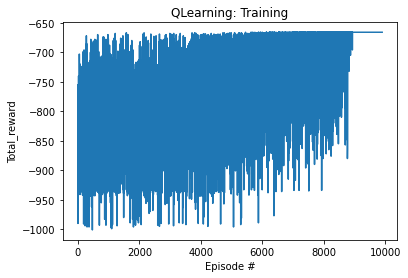

Testing plot for la01 environment


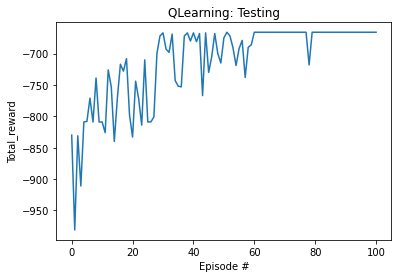

Solution found by Q_learning for la02 environment
From 10000th Episode best policy has makespan 677
Training plot for la02 environment


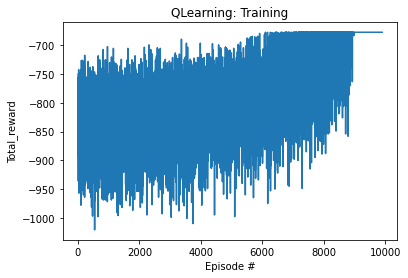

Testing plot for la02 environment


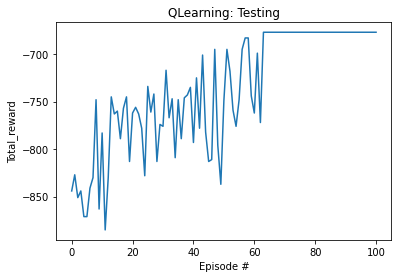

Solution found by Q_learning for la03 environment
From 10000th Episode best policy has makespan 642
Training plot for la03 environment


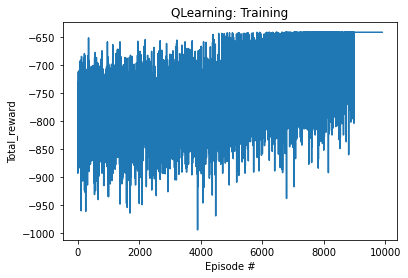

Testing plot for la03 environment


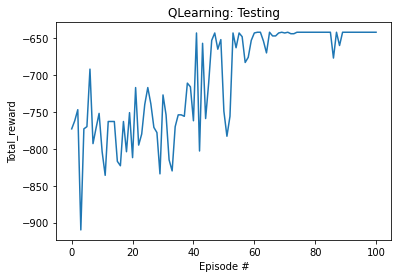

Solution found by Q_learning for la04 environment
From 10000th Episode best policy has makespan 612
Training plot for la04 environment


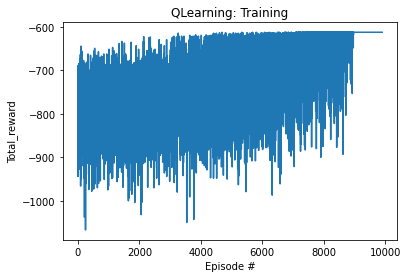

Testing plot for la04 environment


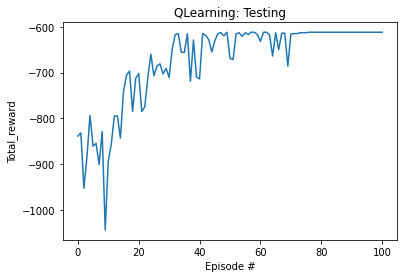

Solution found by Q_learning for la05 environment
From 10000th Episode best policy has makespan 593
Training plot for la05 environment


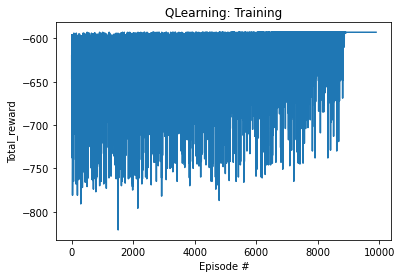

Testing plot for la05 environment


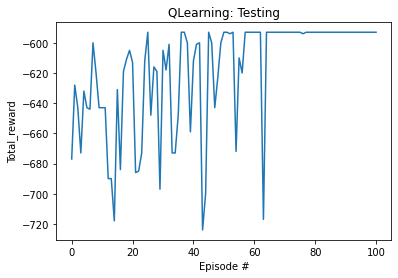

In [15]:
solutions_rs = [0] * 5
a = []
b = []
for i in range(5):
    print('Solution found by Q_learning for {} environment'.format(la_env_names[i]))
    la_training_lists[i], la_testing_lists[i], la_solutions_ql[i], a, b = q_estimation(la_env_list[i], la_env_episodes[i])
    print('Training plot for {} environment'.format(la_env_names[i]))
    plot_learning(la_training_lists[i], "Training")
    print('Testing plot for {} environment'.format(la_env_names[i]))
    plot_learning(la_testing_lists[i], "Testing")

## Comparison

### Makespan Comparison Table

| Env/Algo  | Random Selection | Q_Learning | GA  | OR-Tools |
|-----------|-----------------|------------|-----|----------|
| Small     | 53              | 53         | 53  | 53       |
| Medium    | 58              | 55         | 55  | 55       |
| Large     | 47              | 42         | 42  | 40       |
| Extra Large | 990             | 933        | 986 | 927      |

### Solutions for environments

#### Small Environment - 2 jobs 3 machines 3 operations

In [ ]:
print_allocations(solutions_action_list_ql[0], solutions_time_list_ql[0])

#### Medium Environment - 6 jobs 6 machines 6 operations

In [ ]:
print_allocations(solutions_action_list_ql[1], solutions_time_list_ql[1])

#### Large Environment - 10 jobs 6 machines 6 operations

In [ ]:
print_allocations(solutions_action_list_ql[2], solutions_time_list_ql[2])

#### Extra Large Environment - 10 jobs 11 machines 10 operations

In [ ]:
print_allocations(solutions_action_list_ql[3], solutions_time_list_ql[3])